In [1]:
import os
import glob 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import numpy as np
import pandas as pd

import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, LeakyReLU
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from keras import regularizers
import keras.backend as kb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # set default size of plots

Using TensorFlow backend.


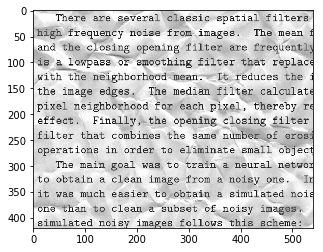

In [2]:
bsb = img.imread('lib/train/216.png')
plt.imshow(bsb, cmap=plt.cm.gray)

In [3]:
target_width = 540
target_height = 420

In [4]:
def load_image_from_dir(img_path):
    file_list = glob.glob(img_path+'/*.png')
    file_list.sort()
    img_list = np.empty((len(file_list), target_height, target_width, 1))
    for i, fig in enumerate(file_list):
        img = image.load_img(fig, color_mode='grayscale', target_size=(target_height, target_width))
        img_array = image.img_to_array(img).astype('float32')
        img_array = img_array / 255.0
        img_list[i] = img_array
    
    return img_list

def train_test_split(data,random_seed=55,split=0.75):
    set_rdm = np.random.RandomState(seed=random_seed)
    dsize = len(data)
    ind = set_rdm.choice(dsize,dsize,replace=False)
    train_ind = ind[:int(0.75*dsize)]
    val_ind = ind[int(0.75*dsize):]
    return data[train_ind],data[val_ind]

def augment_pipeline(pipeline, images, seed=5):
    ia.seed(seed)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

In [5]:
full_train = load_image_from_dir('lib/train')
full_target = load_image_from_dir('lib/train_cleaned')
# test = load_image_from_dir('/kaggle/working/test')

In [6]:
rotate90 = iaa.Rot90(1) # rotate image 90 degrees
rotate180 = iaa.Rot90(2) # rotate image 180 degrees
rotate270 = iaa.Rot90(3) # rotate image 270 degrees
random_rotate = iaa.Rot90((1,3)) # randomly rotate image from 90,180,270 degrees
perc_transform = iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
rotate10 = iaa.Affine(rotate=(10)) # rotate image 10 degrees
rotate10r = iaa.Affine(rotate=(-10)) # rotate image 30 degrees in reverse
crop = iaa.Crop(px=(5, 32)) # Crop between 5 to 32 pixels
hflip = iaa.Fliplr(1) # horizontal flips for 100% of images
vflip = iaa.Flipud(1) # vertical flips for 100% of images
gblur = iaa.GaussianBlur(sigma=(1, 1.5)) # gaussian blur images with a sigma of 1.0 to 1.5
motionblur = iaa.MotionBlur(8) # motion blur images with a kernel size 8

seq_rp = iaa.Sequential([
    iaa.Rot90((1,3)), # randomly rotate image from 90,180,270 degrees
    iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
])

seq_cfg = iaa.Sequential([
    iaa.Crop(px=(5, 32)), # crop images from each side by 5 to 32px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 1.5)) # blur images with a sigma of 0 to 1.5
])

seq_fm = iaa.Sequential([
    iaa.Flipud(1), # vertical flips all the images
    iaa.MotionBlur(k=6) # motion blur images with a kernel size 6
])

In [7]:
pipeline = []
pipeline.append(rotate90)
pipeline.append(rotate180)
pipeline.append(rotate270)
# pipeline.append(random_rotate)
pipeline.append(perc_transform)
# pipeline.append(rotate10)
# pipeline.append(rotate10r)
pipeline.append(crop)
pipeline.append(hflip)
pipeline.append(vflip)
# pipeline.append(gblur)
# pipeline.append(motionblur)
pipeline.append(seq_rp)
pipeline.append(seq_cfg)
pipeline.append(seq_fm)

In [8]:
%%time
processed_train = augment_pipeline(pipeline, full_train.reshape(-1,target_height,target_width))
processed_target = augment_pipeline(pipeline, full_target.reshape(-1,target_height,target_width))

processed_train = processed_train.reshape(-1,target_height,target_width,1)
processed_target = processed_target.reshape(-1,target_height,target_width,1)

processed_train.shape

CPU times: user 20.5 s, sys: 12.3 s, total: 32.7 s
Wall time: 24.9 s


(1584, 420, 540, 1)

In [9]:
# train, val = train_test_split(processed_train, random_seed=9, split=0.8)
# target_train, target_val = train_test_split(processed_target, random_seed=9, split=0.8)

In [10]:
# train, val = train_test_split(full_train, random_seed=9, split=0.8)
# target_train, target_val = train_test_split(full_target, random_seed=9, split=0.8)

In [11]:
# %%time
# pre_train, pre_val = train_test_split(full_train, random_seed=9, split=0.7)
# pre_target_train, pre_target_val = train_test_split(full_target, random_seed=9, split=0.7)

# print(pre_train.shape,pre_val.shape)

# train = augment_pipeline(pipeline, pre_train.reshape(-1,target_height,target_width), seed=10)
# target_train = augment_pipeline(pipeline, pre_target_train.reshape(-1,target_height,target_width), seed=10)

# train = train.reshape(-1,target_height,target_width,1)
# target_train = target_train.reshape(-1,target_height,target_width,1)

# val_pipeline = pipeline + [seq_fm]

# val = augment_pipeline(val_pipeline, pre_val.reshape(-1,target_height,target_width))
# target_val = augment_pipeline(val_pipeline, pre_target_val.reshape(-1,target_height,target_width))

# val = val.reshape(-1,target_height,target_width,1)
# target_val = target_val.reshape(-1,target_height,target_width,1)

# print("Shape of Train set:",train.shape)
# print("Shape of Validation set:",val.shape)

In [12]:
# optimizer = Adam(lr=1e-2, decay=1e-7)
# optimizer = Adam(lr=0.001)
# l2 = 0.01

In [13]:
# ### Multi Layer auto encoder
# input_layer = Input(shape=train[0].shape)

# # encoder
# e = Conv2D(96, (3, 3), activation='relu', padding='same')(input_layer)
# e = Conv2D(96, (3, 3), activation='relu', padding='same')(e)
# e = Conv2D(64, (3, 3), activation='relu', padding='same')(e)
# # e = MaxPooling2D((2, 2), padding='same')(e)

# # decoder
# d = Conv2D(64, (3, 3), activation='relu', padding='same')(e)
# d = Conv2D(96, (3, 3), activation='relu', padding='same')(d)
# d = Conv2D(96, (3, 3), activation='relu', padding='same')(d)
# # d = UpSampling2D((2, 2))(d)
# output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)

In [14]:
# ### Simple Auto encoder

# input_layer = Input(shape=train[0].shape)

# # encoder
# e1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
# e2 = Conv2D(32, (2, 2), activation='relu', padding='same')(e1)
# eb = MaxPooling2D((2, 2), padding='same')(e2)

# # decoder
# d1 = Conv2D(32, (2, 2), activation='relu', padding='same')(eb)
# d2 = Conv2D(64, (3, 3), activation='relu', padding='same')(d1)
# db = UpSampling2D((2, 2))(d2)
# output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(db)

In [15]:
# ### Multi layer auto encoder with regularization
# input_layer = Input(shape=train[0].shape)

# # encoder
# e = Conv2D(128, (3, 3), activation='relu', activity_regularizer=regularizers.l2(l2), padding='same')(input_layer)
# e = Conv2D(128, (3, 3), activation='relu', activity_regularizer=regularizers.l2(l2), padding='same')(e)
# e = Conv2D(64, (3, 3), activation='relu', activity_regularizer=regularizers.l2(l2), padding='same')(e)
# e = MaxPooling2D((2, 2), padding='same')(e)

# # decoder
# d = Conv2D(64, (3, 3), activation='relu', activity_regularizer=regularizers.l2(l2), padding='same')(e)
# d = UpSampling2D((2, 2))(d)
# d = Conv2D(128, (3, 3), activation='relu', activity_regularizer=regularizers.l2(l2), padding='same')(d)
# d = Conv2D(128, (3, 3), activation='relu', activity_regularizer=regularizers.l2(l2), padding='same')(d)
# output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)

In [16]:
### Multi layer auto encoder with LeakyRelu and Normalization
input_layer = Input(shape=(None,None,1))

# encoder
e = Conv2D(64, (3, 3), padding='same')(input_layer)
e = LeakyReLU(alpha=0.3)(e)
e = BatchNormalization()(e)
# e = Conv2D(128, (3, 3), padding='same')(e)
# e = LeakyReLU(alpha=0.3)(e)
# e = BatchNormalization()(e)
e = Conv2D(64, (3, 3), padding='same')(e)
e = LeakyReLU(alpha=0.3)(e)
e = MaxPooling2D((2, 2), padding='same')(e)

# decoder
d = Conv2D(64, (3, 3), padding='same')(e)
d = LeakyReLU(alpha=0.3)(d)
d = BatchNormalization()(d)

d = Conv2D(64, (3, 3), padding='same')(d)
d = LeakyReLU(alpha=0.3)(d)
# e = BatchNormalization()(e)
d = UpSampling2D((2, 2))(d)
# d = Conv2D(128, (3, 3), padding='same')(d)
# d = LeakyReLU(alpha=0.2)(d)
# d = Conv2D(128, (3, 3), padding='same')(d)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)

In [17]:
optimizer = Adam(lr=1e-4, decay=7e-6)
# optimizer = Adam(lr=5e-4, decay=1e-6)
AEmodel = Model(input_layer,output_layer)
AEmodel.compile(loss='mse', optimizer=optimizer)
AEmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0   

In [18]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5,
                               verbose=1, 
                               mode='auto')

checkpoint1 = ModelCheckpoint('best_val_loss.h5',
                             monitor='val_loss',
                             save_best_only=True)

checkpoint2 = ModelCheckpoint('best_loss.h5',
                             monitor='loss',
                             save_best_only=True)

In [ ]:
history = AEmodel.fit(processed_train, processed_target,
                                     batch_size=16,
                                     epochs=30,
                                     callbacks=[checkpoint2])
#                                      validation_data=(val, target_val))

In [ ]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
# full_model_preds = AEmodel.predict(test)
full_train_preds = AEmodel.predict(full_train)

AEmodel.load_weights('best_loss.h5')
AEmodel.compile(loss='mse', optimizer=optimizer)
# preds = AEmodel.predict(test)
train_preds = AEmodel.predict(full_train)

In [ ]:
AEmodel.save('AutoEncoderModel.h5')

## Loading a saved model

In [20]:
AEmodel = load_model('lib/saved_models/AutoEncoderModel.h5')

In [41]:
AEmodel.evaluate(full_train, full_target, batch_size=16)

144/144 [==============================] - 24s 164ms/step


0.0005147697520442307

In [21]:
full_train_preds = AEmodel.predict(full_train)
train_preds = AEmodel.predict(full_train)

(1599, 1200, 4)


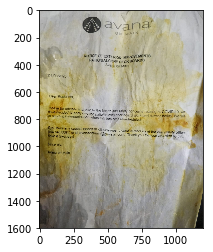

In [33]:
bsb = img.imread('https://github.com/sampath9dasari/GSU/raw/master/denoise_test.png')
print(bsb.shape)
# test = img.imread('../kaggle/working/test/1.png')
plt.imshow(bsb, cmap=plt.cm.gray)

(1599, 1200)


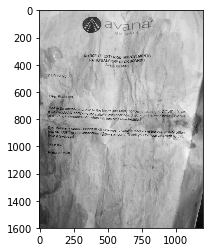

In [36]:
gray_image = cv2.cvtColor(bsb, cv2.COLOR_BGR2GRAY)
print(gray_image.shape)
plt.imshow(gray_image,cmap=plt.cm.gray)

In [38]:
gpred = AEmodel.predict(gray_image.reshape(1,gray_image.shape[0],gray_image.shape[1],1))
print(gpred.shape)

(1, 1600, 1200, 1)


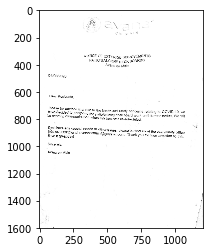

In [39]:
plt.imshow(gpred.reshape(1600,1200),cmap=plt.cm.gray)

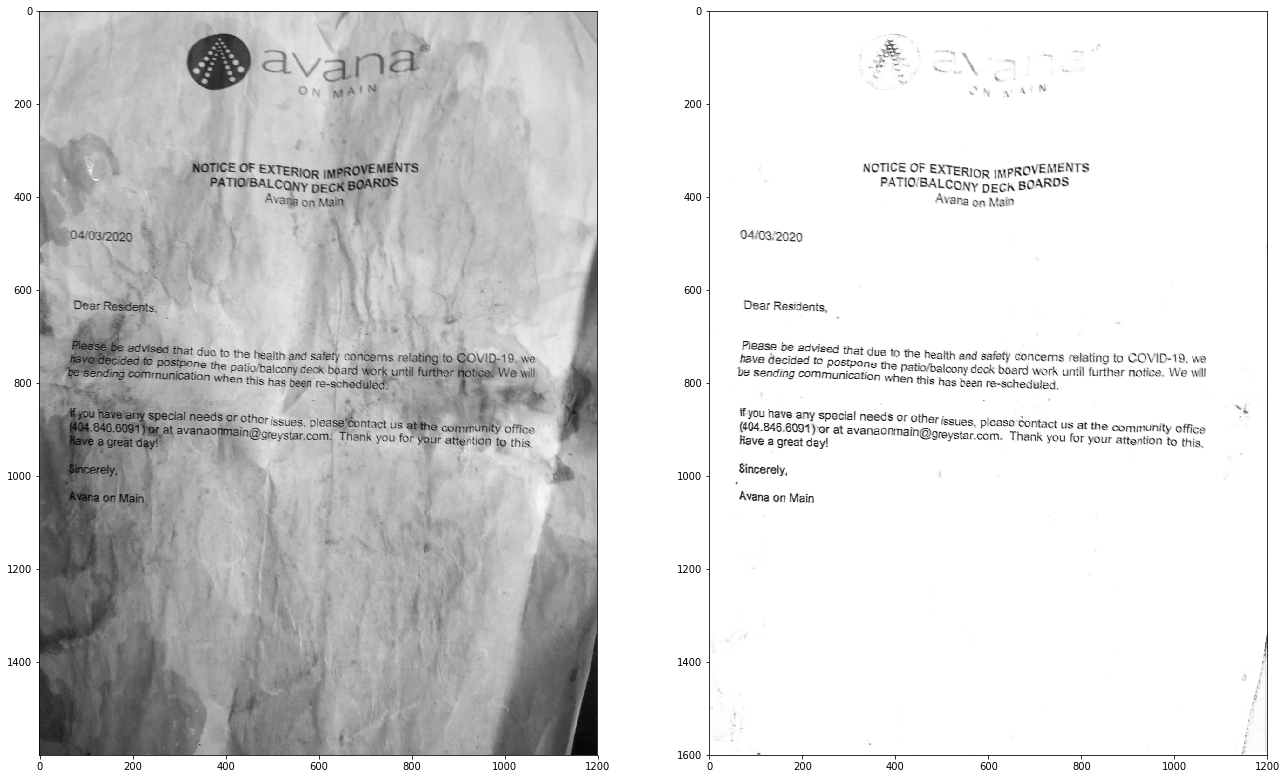

In [40]:
fig, ax = plt.subplots(1,2,figsize=(22,16))
ax[0].imshow(gray_image, cmap=plt.cm.gray)
ax[1].imshow(gpred.reshape(1600,1200), cmap=plt.cm.gray)

144/144 [==============================] - 23s 163ms/step


0.0005147697520442307

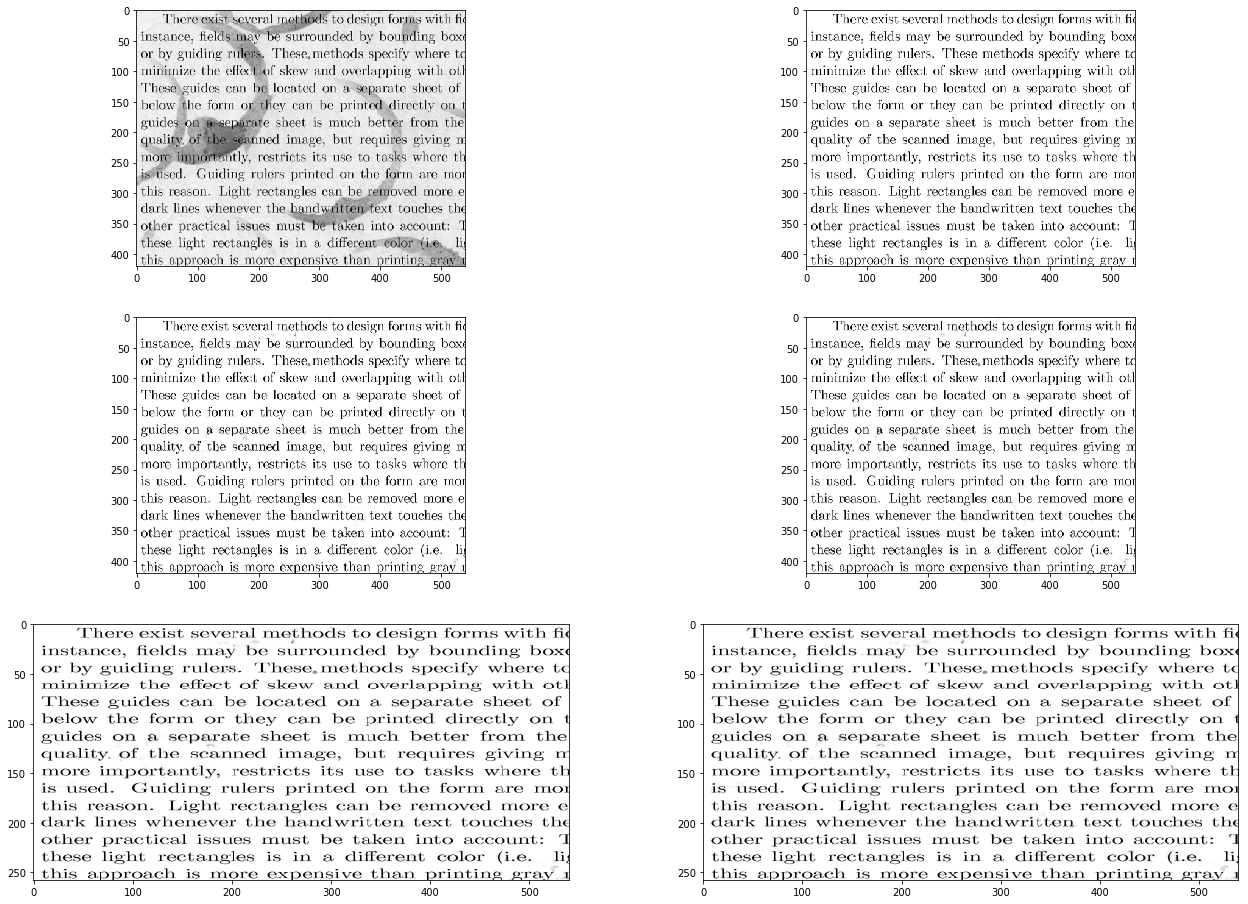

In [23]:
fig, ax = plt.subplots(3,2,figsize=(22,16))
ax[0][0].imshow(full_train[42].reshape(target_height,target_width), cmap=plt.cm.gray)
ax[0][1].imshow(full_target[42].reshape(target_height,target_width), cmap=plt.cm.gray)
ax[1][0].imshow(full_train_preds[42].reshape(target_height,target_width), cmap=plt.cm.gray)
ax[1][1].imshow(train_preds[42].reshape(target_height,target_width), cmap=plt.cm.gray)
reshape = cv2.resize(full_train_preds[42],(target_width,258))
ax[2][0].imshow(reshape.reshape(258,target_width), cmap=plt.cm.gray)
reshape = cv2.resize(train_preds[42],(target_width,258))
ax[2][1].imshow(reshape.reshape(258,target_width), cmap=plt.cm.gray)

In [ ]:
# %%time
# ids = []
# vals = []
# file_list = glob.glob('/kaggle/working/test/*.png')
# file_list.sort()
# for i, f in enumerate(file_list):
#     file = os.path.basename(f)
#     imgid = int(file[:-4])
#     test_img = cv2.imread(f, 0)
#     img_shape = test_img.shape
# #     print('processing: {}'.format(imgid))
# #     print(img_shape)
#     preds_reshaped = cv2.resize(preds[i], (img_shape[1], img_shape[0]))
#     for r in range(img_shape[0]):
#         for c in range(img_shape[1]):
#             ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
#             vals.append(preds_reshaped[r, c])

# print('Writing to csv file')
# pd.DataFrame({'id': ids, 'value': vals}).to_csv('submission.csv', index=False)

In [ ]:
#Load and Scale test images into one big list.
file_list = glob.glob('lib/test/*.png')
file_list.sort()
test_size = len(file_list)

#initailize data arrays.
img_ids = []
test = []

#read data
for i, img_dir in enumerate(file_list):
    file = os.path.basename(img_dir)
    imgid = int(file[:-4])
    img_ids.append(imgid)
    img_pixels = image.load_img(img_dir, color_mode='grayscale')
    w, h = img_pixels.size
    test.append(np.array(img_pixels).reshape(1, h, w, 1) / 255.)
    
print('Test sample shape: ', test[0].shape)
print('Test sample dtype: ', test[0].dtype)

In [ ]:
#Predict test images one by one and store them into a list.
test_preds = []
for img in test:
    test_preds.append(AEmodel.predict(img)[0, :, :, 0])

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(22,12))
ax[0].imshow(test[45].reshape(test[45].shape[1],test[45].shape[2]), cmap=plt.cm.gray)
ax[1].imshow(test_preds[45].reshape(test[45].shape[1],test[45].shape[2]), cmap=plt.cm.gray)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(test[42].reshape(test[42].shape[1],test[42].shape[2]), cmap=plt.cm.gray)
ax[1].imshow(test_preds[42].reshape(test[42].shape[1],test[42].shape[2]), cmap=plt.cm.gray)

In [ ]:
# First column will be raw data, second column will be the corresponding cleaned images.
f, ax = plt.subplots(2,3, figsize=(20,10))
f.subplots_adjust(hspace = .1, wspace=.05)
for i, (img, lbl) in enumerate(zip(test[:3], test_preds[:3])):
    ax[0, i].imshow(img[0,:,:,0], cmap='gray')
    ax[0, i].title.set_text('Original Image')
    ax[0, i].axis('off')

    ax[1, i].imshow(lbl, cmap='gray')
    ax[1, i].title.set_text('Cleaned Image')
    ax[1, i].axis('off')
plt.show()

In [ ]:
#Flatten the 'test_preds' list into 1-d list for submission.
submit_vector = []
submit_ids = []
for imgid, img in zip(img_ids,test_preds):
    h, w = img.shape
    for c in range(w):
        for r in range(h):
            submit_ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            submit_vector.append(img[r,c])
print(len(submit_vector))

In [ ]:
len(submit_vector)

In [ ]:
sample_csv = pd.read_csv('lib/sampleSubmission.csv')
sample_csv.head(10)

In [ ]:
id_col = sample_csv['id']
value_col = pd.Series(submit_vector, name='value')
submission = pd.concat([id_col, value_col], axis=1)
submission.head(10)

In [ ]:
submission.to_csv('submission.csv',index = False)